__A simulation of Anomaly Detection of Electricity Usage in a Household__

In [85]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
import pickle

from numpy.random import seed
from sklearn.utils import shuffle
from pylab import rcParams
from tensorflow import set_random_seed

from keras.models import Model, load_model, Sequential
from keras.models import model_from_json
from keras.layers.core import Dense
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import optimizers

In [86]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8
LABELS = ["Healthy", "Unhealthy"]

__Load the power consumption data recorded over a span of 4 years for a household__

In [87]:
household_pw_df = pd.read_csv("household_power_consumption.csv", index_col='Index', header=0)

In [88]:
household_pw_df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Index,,,,,,,,,
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


**Retrieve data over a 5 day period for quick development and deployment of mode. Only 5 days used as more data will result in more training time etc...**

In [89]:
household_pw_trunc_df = household_pw_df[986796:993996]
household_pw_trunc_df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Index,,,,,,,,,
986796,1/11/2008,00:00:00,0.602,0.184,242.500,2.800,0.000,0.000,0.0
986797,1/11/2008,00:01:00,0.600,0.182,242.130,2.800,0.000,0.000,0.0
986798,1/11/2008,00:02:00,0.528,0.078,241.830,2.400,0.000,0.000,0.0
986799,1/11/2008,00:03:00,0.526,0.076,241.000,2.400,0.000,0.000,0.0
986800,1/11/2008,00:04:00,0.524,0.076,240.780,2.400,0.000,0.000,0.0
...,...,...,...,...,...,...,...,...,...
993991,5/11/2008,23:55:00,0.338,0.070,240.580,1.400,0.000,2.000,0.0
993992,5/11/2008,23:56:00,0.318,0.064,240.530,1.400,0.000,1.000,0.0
993993,5/11/2008,23:57:00,0.350,0.092,240.290,1.600,1.000,2.000,0.0


__Quick EDA on dataset__

In [90]:
household_pw_trunc_df.describe()

,Sub_metering_3
count,7200.000000
mean,2.655972
std,6.276834
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,19.000000


In [91]:
household_pw_trunc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 986796 to 993995
Data columns (total 9 columns):
Date                     7200 non-null object
Time                     7200 non-null object
Global_active_power      7200 non-null object
Global_reactive_power    7200 non-null object
Voltage                  7200 non-null object
Global_intensity         7200 non-null object
Sub_metering_1           7200 non-null object
Sub_metering_2           7200 non-null object
Sub_metering_3           7200 non-null float64
dtypes: float64(1), object(8)
memory usage: 562.5+ KB


In [92]:
household_pw_trunc_df.fillna('0')

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Index,,,,,,,,,
986796,1/11/2008,00:00:00,0.602,0.184,242.500,2.800,0.000,0.000,0.0
986797,1/11/2008,00:01:00,0.600,0.182,242.130,2.800,0.000,0.000,0.0
986798,1/11/2008,00:02:00,0.528,0.078,241.830,2.400,0.000,0.000,0.0
986799,1/11/2008,00:03:00,0.526,0.076,241.000,2.400,0.000,0.000,0.0
986800,1/11/2008,00:04:00,0.524,0.076,240.780,2.400,0.000,0.000,0.0
...,...,...,...,...,...,...,...,...,...
993991,5/11/2008,23:55:00,0.338,0.070,240.580,1.400,0.000,2.000,0.0
993992,5/11/2008,23:56:00,0.318,0.064,240.530,1.400,0.000,1.000,0.0
993993,5/11/2008,23:57:00,0.350,0.092,240.290,1.600,1.000,2.000,0.0


In [93]:
household_pw_trunc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 986796 to 993995
Data columns (total 9 columns):
Date                     7200 non-null object
Time                     7200 non-null object
Global_active_power      7200 non-null object
Global_reactive_power    7200 non-null object
Voltage                  7200 non-null object
Global_intensity         7200 non-null object
Sub_metering_1           7200 non-null object
Sub_metering_2           7200 non-null object
Sub_metering_3           7200 non-null float64
dtypes: float64(1), object(8)
memory usage: 562.5+ KB


In [97]:
household_pw_trunc_df.shape

(7200, 10)

__Start of model development__

In [98]:
healthy_df = household_pw_trunc_df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

In [99]:
from sklearn.model_selection import train_test_split

healthy_train, healthy_test = train_test_split(healthy_df, test_size=0.1, random_state=42)

In [100]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
scaler = StandardScaler()  # MinMaxScaler used for DS1B4_V12
                            # DS1B4_V10, V13, TiedAE_DS1B4_V1 uses StandardScaler

X_train = pd.DataFrame(scaler.fit_transform(healthy_train), 
                       columns=healthy_train.columns, 
                       index=healthy_train.index)

In [101]:
healthy_test = pd.DataFrame(scaler.transform(healthy_test), 
                      columns=healthy_test.columns,
                      index=healthy_test.index)

In [102]:
from keras import backend as K
from keras.engine import Layer, InputSpec
from keras import activations, initializers, regularizers, constraints
from keras.constraints import UnitNorm, Constraint
from keras.layers import InputSpec

from numpy.random import seed

In [106]:
X_train.shape[1]

7

In [107]:
def UntiedAE_oneHL():
    """Main design of an Autoencoder architecture
    
    Key Parameter:
    No. of input nodes (features) = no. of output nodes 
    
    Returns:
    A Sparse Autoencoder
    
    """
    
    act_func = 'relu'
    encoder1 = Dense(50,activation=act_func, kernel_regularizer = regularizers.l2(0.001), kernel_initializer='he_uniform',
                    input_shape=(X_train.shape[1],), use_bias=False, activity_regularizer=regularizers.l1(10e-5))
    # encoder2 = Dense(30,activation=act_func, kernel_initializer='glorot_uniform', use_bias=False)
    decoder1 = Dense(7, activation="linear", use_bias=False)
    # decoder2 = DenseTied(5, activation=act_func, tied_to=encoder1, use_bias=False)
    autoencoder = Sequential()
    autoencoder.add(encoder1)
    # autoencoder.add(encoder2)
    autoencoder.add(decoder1)
    # autoencoder.add(decoder2)
    autoencoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mse'])
    return autoencoder

In [108]:
autoencoder = UntiedAE_oneHL()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                350       
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 350       
Total params: 700
Trainable params: 700
Non-trainable params: 0
_________________________________________________________________


In [109]:
NUM_EPOCHS = 100
BATCH_SIZE= 10

# Save a model of the trained AE for future deployment.
checkpointer = ModelCheckpoint(filepath="Results\\BaselineAE_V1.h5",
                               verbose=0,save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=True)

history = autoencoder.fit(X_train, X_train,
                    batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,
                    validation_split=0.1, 
                    verbose = 1, shuffle=True,
                    callbacks=[checkpointer, tensorboard]).history



Train on 5832 samples, validate on 648 samples


Epoch 1/100
5832/5832 [==============================] - 2s 425us/step - loss: 0.4918 - acc: 0.6888 - mean_squared_error: 0.3966 - val_loss: 0.1387 - val_acc: 0.8241 - val_mean_squared_error: 0.0490
Epoch 2/100
5832/5832 [==============================] - 1s 232us/step - loss: 0.1108 - acc: 0.8383 - mean_squared_error: 0.0271 - val_loss: 0.0952 - val_acc: 0.8503 - val_mean_squared_error: 0.0175
Epoch 3/100
5832/5832 [==============================] - 2s 296us/step - loss: 0.0844 - acc: 0.8668 - mean_squared_error: 0.0124 - val_loss: 0.0759 - val_acc: 0.8580 - val_mean_squared_error: 0.0096
Epoch 4/100
5832/5832 [==============================] - 1s 247us/step - loss: 0.0687 - acc: 0.8872 - mean_squared_error: 0.0077 - val_loss: 0.0618 - val_acc: 0.8966 - val_mean_squared_error: 0.0061
Epoch 5/100
5832/5832 [==============================] - 1s 229us/step - loss: 0.0560 - acc: 0.9170 - mean_squared_error: 0.0053 - val_loss: 0.0500 - val

5832/5832 [==============================] - 1s 223us/step - loss: 0.0016 - acc: 0.9757 - mean_squared_error: 5.2802e-04 - val_loss: 0.0025 - val_acc: 0.9799 - val_mean_squared_error: 0.0015
Epoch 38/100
5832/5832 [==============================] - 1s 227us/step - loss: 0.0018 - acc: 0.9762 - mean_squared_error: 7.9768e-04 - val_loss: 0.0019 - val_acc: 0.9830 - val_mean_squared_error: 8.5580e-04
Epoch 39/100
5832/5832 [==============================] - 2s 318us/step - loss: 0.0015 - acc: 0.9787 - mean_squared_error: 5.0938e-04 - val_loss: 0.0013 - val_acc: 0.9830 - val_mean_squared_error: 3.3901e-04
Epoch 40/100
5832/5832 [==============================] - 2s 311us/step - loss: 0.0015 - acc: 0.9775 - mean_squared_error: 5.7058e-04 - val_loss: 0.0014 - val_acc: 0.9830 - val_mean_squared_error: 4.0021e-04
Epoch 41/100
5832/5832 [==============================] - 2s 329us/step - loss: 0.0014 - acc: 0.9787 - mean_squared_error: 4.5038e-04 - val_loss: 0.0013 - val_acc: 0.9892 - val_mean_squ

5832/5832 [==============================] - 2s 314us/step - loss: 0.0015 - acc: 0.9763 - mean_squared_error: 8.2296e-04 - val_loss: 0.0015 - val_acc: 0.9753 - val_mean_squared_error: 7.7540e-04
Epoch 77/100
5832/5832 [==============================] - 1s 249us/step - loss: 0.0010 - acc: 0.9801 - mean_squared_error: 3.4451e-04 - val_loss: 9.4075e-04 - val_acc: 0.9830 - val_mean_squared_error: 2.6396e-04
Epoch 78/100
5832/5832 [==============================] - 1s 221us/step - loss: 0.0015 - acc: 0.9777 - mean_squared_error: 8.5475e-04 - val_loss: 0.0015 - val_acc: 0.9861 - val_mean_squared_error: 7.8209e-04
Epoch 79/100
5832/5832 [==============================] - 1s 222us/step - loss: 0.0010 - acc: 0.9811 - mean_squared_error: 3.2707e-04 - val_loss: 0.0011 - val_acc: 0.9877 - val_mean_squared_error: 3.9576e-04
Epoch 80/100
5832/5832 [==============================] - 1s 221us/step - loss: 0.0012 - acc: 0.9803 - mean_squared_error: 5.7805e-04 - val_loss: 9.0846e-04 - val_acc: 0.9846 - 

<function matplotlib.pyplot.show(*args, **kw)>

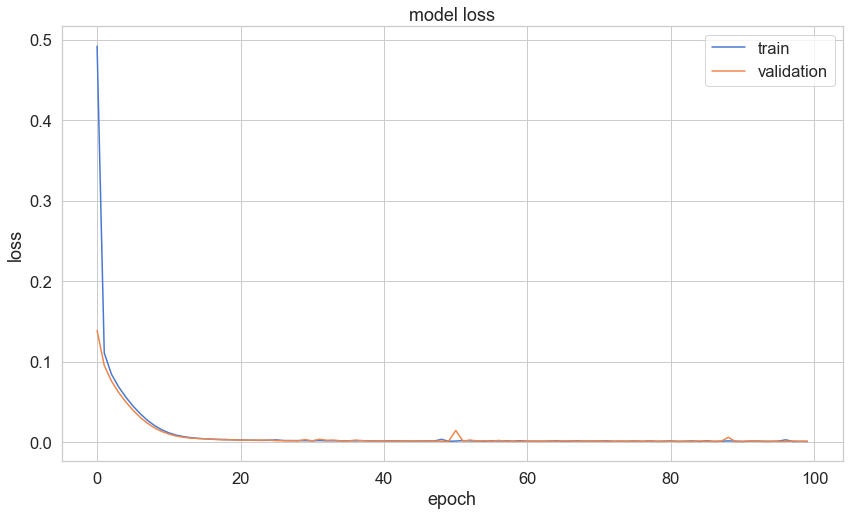

In [110]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

pylab.savefig("Results\BaselineAE_loss_V1.png")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

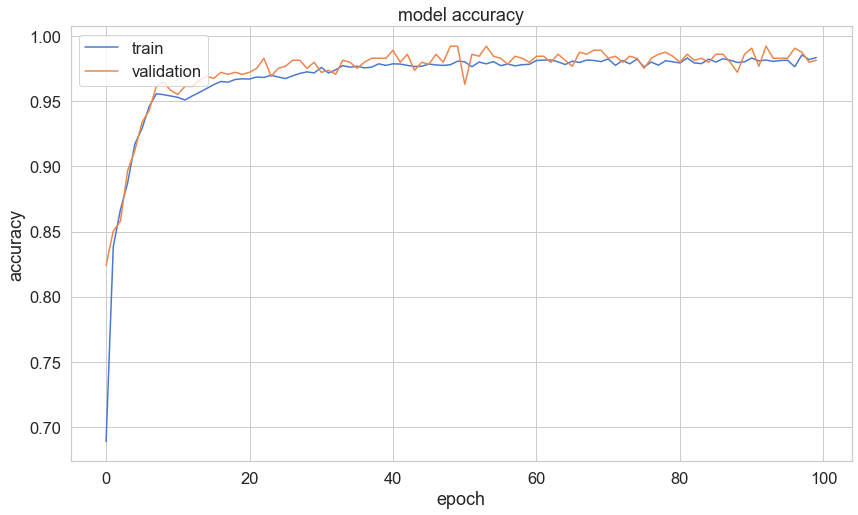

In [111]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

pylab.savefig("Results\\BaselineAE_acc_V1.png")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

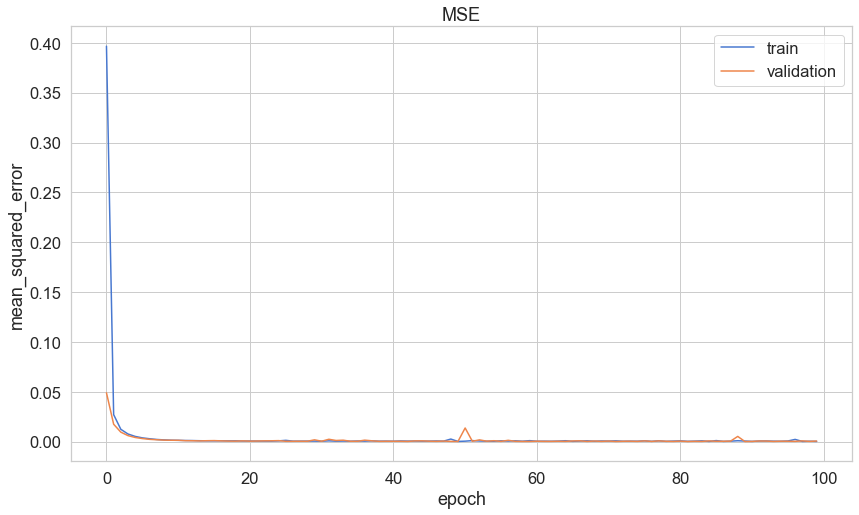

In [112]:
plt.plot(history['mean_squared_error'])
plt.plot(history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

pylab.savefig("Results\\BaselineAE_mse_V1.png")
plt.show

__Calculate an anomaly threshold__

In [113]:
k = 1

Threshold = np.max(history['mean_squared_error'][41:]) + k*(np.std(history['mean_squared_error'][41:]))
Threshold

0.00301455231969302

__Check if an unseen dataset is anomalous or not__

In [26]:
test_loss, test_acc, test_mse = autoencoder.evaluate(healthy_test, healthy_test, verbose=2)

if (test_mse > Threshold):
    print('Anomalaous Data detected')
else:
    print('Healthy Data')

Healthy Data


In [ ]:
# If anomalous data, raise an alarm to IBM Watson Assistant